In [86]:
import pandas as pd
import numpy as np
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

dfs = pd.read_excel("Acme.xlsx")

dfs_copy = dfs.copy()

# This is for predicting policies sold:

#X = dfs_copy[['click', 'cost', 'currently_insured', 'number_of_vehicles', 'number_of_drivers', 'marital_status', 'rank']]
#y = dfs_copy['policies sold']



# This is for predicting rank:

X = dfs_copy[['currently_insured', 'number_of_vehicles', 'number_of_drivers', 'marital_status']]
y = dfs_copy['rank']

# we take out impression_id since it is just the index + 1.


dfs_copy.head(20)

,impression_id,click,cost,currently_insured,number_of_vehicles,number_of_drivers,marital_status,rank,policies sold
0,1,1,10,N,1,1,M,1,1
1,2,0,10,N,2,1,M,4,0
2,3,0,10,N,1,1,S,2,0
3,4,0,10,Y,2,1,M,5,0
4,5,0,10,Y,2,2,S,4,0
5,6,0,10,N,1,2,M,3,0
6,7,0,10,N,1,2,M,3,0
7,8,0,10,N,1,1,M,4,0
8,9,1,10,N,2,1,M,3,1
9,10,0,10,Y,1,1,M,2,0


In [87]:
# this is for predicting policies sold:
#cols = ['click','currently_insured','marital_status','number_of_vehicles','number_of_drivers','rank']

# this is for predicting rank:
cols = ['currently_insured','marital_status','number_of_vehicles','number_of_drivers']

ycol = ['rank']

X[cols] = X[cols].astype(str)
dummies = pd.get_dummies(X[cols])
ydummies = pd.get_dummies(y)

X_prime = pd.concat([X[[c for c in X.columns if c not in cols]],dummies],axis=1, sort=False)

# Here we select which rank to train & predict for:

rank = 5
y_prime = ydummies.loc[:,rank]

y_prime.head(15)

c:\python3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0     0
1     0
2     0
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    0
13    0
14    0
Name: 5, dtype: uint8

In [88]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_prime,y_prime,test_size = .25,random_state = 614,shuffle = True,stratify = y)

X_train.head()

,currently_insured_N,currently_insured_Y,marital_status_M,marital_status_S,number_of_vehicles_1,number_of_vehicles_2,number_of_drivers_1,number_of_drivers_2
8184,0,1,1,0,1,0,0,1
4333,1,0,1,0,0,1,1,0
9294,1,0,1,0,1,0,1,0
9810,0,1,1,0,1,0,1,0
8519,0,1,1,0,1,0,0,1


In [89]:
# First we'll try a logistic regression for rank.

from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

log_reg = LogisticRegression(max_iter = 10000)

cutoffs = range(100)

cv = StratifiedKFold(5, shuffle = True, random_state=614)

acc = np.empty((len(cutoffs)))
prec = np.empty((len(cutoffs)))
rec = np.empty((len(cutoffs)))
a = np.empty((5, len(cutoffs)))
p = np.empty((5, len(cutoffs)))
r = np.empty((5, len(cutoffs)))


for cutoff in cutoffs:
        
    j=0
    for train_idx, test_idx in cv.split(X_train,y_train):

        X_train2 = X_train.iloc[train_idx]
        y_train2 = y_train.iloc[train_idx]
        X_test2 = X_train.iloc[test_idx]
        y_test2 = y_train.iloc[test_idx]
        
        clone_log_reg = clone(log_reg)
        clone_log_reg.fit(X_train2,y_train2.ravel())
        
        
        y_prob = clone_log_reg.predict_proba(X_test2)[:,1]
        y_predict = 1*(y_prob >= cutoff/100)
            
        a[j,cutoff] = 100*np.round(sum(y_predict == y_test2.ravel())/len(y_predict),5)

        tp_train = np.sum(((y_predict == 1) & (y_test2 == 1)))
        fp_train = np.sum(((y_predict == 1) & (y_test2 == 0)))
        fn_train = np.sum(((y_predict == 0) & (y_test2 == 1)))
        tn_train = np.sum(((y_predict == 0) & (y_test2 == 0)))
            
        if tp_train + fp_train != 0:
            p[j,cutoff] = 100*np.round((tp_train/(tp_train + fp_train)),5)
        else:
            p[j,cutoff] = 1
        if tp_train + fn_train != 0:
            r[j,cutoff] = 100*np.round((tp_train/(tp_train + fn_train)),5)
        else:
            r[j,cutoff] = 1
            
        j = j + 1
    
    acc[cutoff] = np.mean(a[:,cutoff])
    prec[cutoff] = np.mean(p[:,cutoff])
    rec[cutoff] = np.mean(r[:,cutoff])
        
        
# Here we find which cutoff maximizes accuracy,precision,&recall over all features (via mean):
    
j = 0
k = 0
l = 0
for cutoff in cutoffs[1:]:
    if j <= acc[cutoff]:
        j = acc[cutoff]
    if k <= prec[cutoff]:
        k = prec[cutoff]
    if l <= rec[cutoff]:
        l = rec[cutoff]
        
finalcutoffacc = -1
finalcutoffprec = -1
finalcutoffrec = -1                      # a check to see if something goes wrong...

# Here we decide where our best cutoff is
for cutoff in cutoffs[1:]:
    if acc[cutoff] == j:
        finalcutoffacc = cutoff
    if prec[cutoff] == k:
        finalcutoffprec = cutoff
    if rec[cutoff] == l:
        finalcutoffrec = cutoff


finalacc = acc[finalcutoffacc]
finalprec = prec[finalcutoffprec]
finalrec = rec[finalcutoffrec]
print(finalcutoffacc)                  # thus the best accuracy cutoff is at 0.49
print(finalcutoffprec)                  # thus the best precision cutoff is at 0.52
print(finalcutoffrec)                  # thus the best recall cutoff is at 0.17



49
52
17


In [90]:
# Here we reset the recall to use precision's cutoff, since any cutoff optimized for recall only will
# inevitably use the smallest cutoff to minimize FN and thus make TP/(TP+FN) as close to 1 as possible
finalrec = rec[finalcutoffprec]

print("accuracy:",finalacc,"%")
print("precision:",finalprec,"%")
print("recall:",finalrec,"%")

# recall and precision are awful here.
# rank 1: acc 88.68%, prec 50.38%, rec 40.29%
# rank 2: acc 85.60%, prec 31.80%, rec 19.62%
# rank 3: acc 75.29%, prec 32.30%, rec 9.60%
# rank 4: acc 75.32%, prec 30.24%, rec 32.25%
# rank 5: acc 75.38%, prec 55.61%, rec 4.26%

accuracy: 75.3866 %
precision: 55.61880000000001 %
recall: 4.267799999999999 %


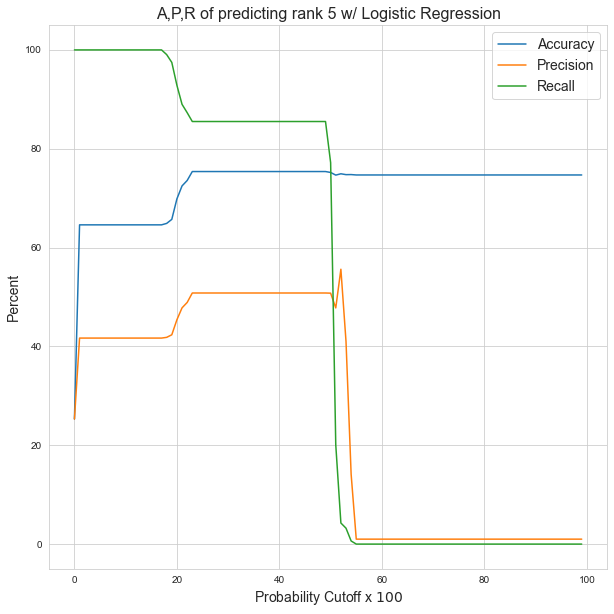

In [91]:
# Plotting: 

sns.set_style("whitegrid")
plt.figure(figsize=(10,10))

plt.plot(acc,label="Accuracy")
plt.plot(prec,label="Precision")
plt.plot(rec,label="Recall")

plt.xlabel("Probability Cutoff x $100$",fontsize=14)
plt.ylabel("Percent",fontsize=14)
plt.title("A,P,R of predicting rank " +str(rank)+ " w/ Logistic Regression",fontsize=16)
plt.legend(fontsize=14)
plt.show()

